In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
data_dir = r"D:\project\signaturRecognition\notebook\data"

In [31]:
class_name = os.listdir(data_dir)
len(class_name)

2

In [32]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms as T, datasets


In [33]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))


Device: cuda


In [34]:
data_transform = T.Compose([
    T.Resize(size=(224,224)),
    T.RandomRotation(degrees=(-20,+20)),
    T.ToTensor(),
    T.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])


In [35]:
data=datasets.ImageFolder(data_dir,transform=data_transform)
total_count=len(data)

In [36]:
total_count

2640

In [37]:
data.classes

['full_forg', 'full_org']

In [38]:
train_count=int(0.6* total_count)
valid_count=int(0.3* total_count)
test_count=total_count-train_count-valid_count
train_data,val_data,test_data=torch.utils.data.random_split(data,(train_count,valid_count,test_count))

In [39]:
train_data.dataset

Dataset ImageFolder
    Number of datapoints: 2640
    Root location: D:\project\signaturRecognition\notebook\data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [40]:
len(train_data.indices)

1584

In [41]:
len(test_data.indices)

264

In [42]:
len(val_data.indices)

792

In [43]:
def show_image(image,label,get_denormalize=True):
    image=image.permute(1,2,0)
    mean=torch.FloatTensor([0.485,0.456,0.406])
    std=torch.FloatTensor([0.229,0.224,0.225])
    if get_denormalize==True:
        image=image*std+mean
        image=np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
    else:
        plt.show(image)
        plt.title(label)
def show_grid(image,title = None):
    image = image.permute(1,2,0)
    mean = torch.floatTensor([0.485,0.456,0.406])
    std = torch.FloatTensor([0.229,0.224,0.225])

    image = image*std+mean
    image = np.clip(image,0,1)

    plt.figure(figsize=[15,15])
    plt.imshow(image)
    if title != None:
        plt.title(title)

def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,toop_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_ture.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))
        
        


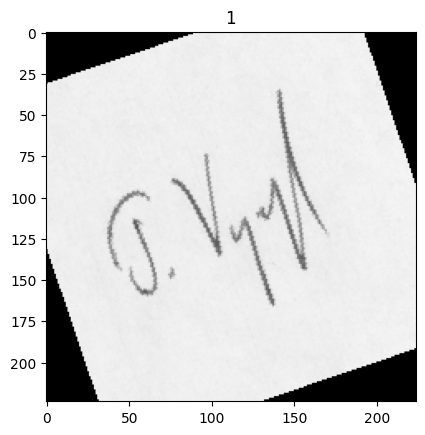

In [44]:
img,label=train_data[0]
show_image(img,label)

In [45]:
trainloader=DataLoader(train_data,batch_size=32,shuffle=True)
print("No. of  batches in trainloader:{} ".format(len(trainloader)))
print("No. of Total examples:{} ".format(len(trainloader.dataset)))

validationloader=DataLoader(val_data,batch_size=32,shuffle=True)
print("No. of  batches in validationloader:{} ".format(len(validationloader)))
print("No. of Total examples:{} ".format(len(validationloader.dataset)))

testloader=DataLoader(test_data,batch_size=32,shuffle=False)
print("No. of  batches in testloader:{} ".format(len(testloader)))
print("No. of Total examples:{} ".format(len(testloader.dataset)))

No. of  batches in trainloader:50 
No. of Total examples:1584 
No. of  batches in validationloader:25 
No. of Total examples:792 
No. of  batches in testloader:9 
No. of Total examples:264 


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms

In [65]:
model = models.resnet34(pretrained = True)    

In [67]:
import torch
import torch.nn as nn
import torchvision.models as models

# Example: load ResNet18
model = models.resnet18(pretrained=True)

# ✅ Step 1: Save in_features BEFORE replacing
in_features = model.fc.in_features

# ✅ Step 2: Replace the fully connected layer
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(in_features, len(class_name))
)

# ✅ Step 3: Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ✅ Step 4: Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [70]:
from tqdm import tqdm

def train(model, criterion, optimizer, train_dataloader, test_dataloader, device):
    total_train_loss = 0
    total_test_loss = 0

    # Training
    model.train()
    with tqdm(train_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description('Training')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            output = model(images)
            loss = criterion(output, idxs)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

    # Testing / Validation
    model.eval()
    with torch.no_grad():
        with tqdm(test_dataloader, unit='batch', leave=False) as pbar:
            pbar.set_description('Testing')
            for images, idxs in pbar:
                images = images.to(device, non_blocking=True)
                idxs = idxs.to(device, non_blocking=True)
                output = model(images)
                loss = criterion(output, idxs)
                total_test_loss += loss.item()

    train_loss = total_train_loss / len(train_dataloader.dataset)
    test_loss = total_test_loss / len(test_dataloader.dataset)

    print(f'Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}')


In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

epochs = 5
for i in range(epochs):
    print(f"\nEpoch {i+1}/{epochs}")
    train(model, criterion, optimizer, trainloader, validationloader, device=device)



Epoch 1/5


Train loss: 0.0003 | Test loss: 0.0001

Epoch 2/5


Train loss: 0.0004 | Test loss: 0.0001

Epoch 3/5


Train loss: 0.0005 | Test loss: 0.0001

Epoch 4/5


Train loss: 0.0002 | Test loss: 0.0000

Epoch 5/5


Train loss: 0.0002 | Test loss: 0.0000


In [79]:
Path = r'D:\\project\\signaturRecognition\\notebook\\model.pt'
torch.save(model,Path)

In [80]:
pwd

'D:\\project\\signaturRecognition\\notebook'

In [86]:

# Load the full model (architecture + weights)
model = torch.load(Path, weights_only=False)  # explicitly disable weights_only
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [97]:
from tqdm import tqdm

def evaluate(model, criterion, test_dataloader, device):
    total_test_loss = 0
    model.eval()

    with torch.no_grad():  # important for evaluation
        with tqdm(test_dataloader, unit='batch', leave=False) as pbar:
            pbar.set_description('Testing')
            for images, idxs in pbar:
                images = images.to(device, non_blocking=True)
                idxs = idxs.to(device, non_blocking=True)

                output = model(images)
                loss = criterion(output, idxs)
                total_test_loss += loss.item()

    # Use length of dataset, not val_data
    test_loss = total_test_loss / len(test_dataloader.dataset)
    print(f'Test loss: {test_loss:.4f}')


In [98]:
evaluate(model, criterion, testloader, device)


Test loss: 0.0000


In [99]:
label_names=data.classes
label_names

['full_forg', 'full_org']

In [107]:
from PIL import Image

image=Image.open(r"D:\project\signaturRecognition\notebook\data\full_org\original_19_13.png")
preprocess=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.Grayscale(3),
    transforms.ToTensor()
])
image=preprocess(image)
image=image[:3]
image = image.unsqueeze(0).to (device)
with torch.no_grad():
    logits = model(image)
    probs = torch.softmax(logits, dim=1)
    pred_label = torch.argmax(probs,dim=1)
print(f'prediction label: {pred_label.item()}')
predicted_class_name = label_names[pred_label.item()]
print(f'predicted class name: {predicted_class_name}')



prediction label: 1
predicted class name: full_org
